# Fallback - Insert Retention Scores NHL-Jets
* StellarAlgo Data Science
* Ryan Kazmerik, Grant Donst
* Sept 29, 2022

In [1]:
import boto3
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from datetime import datetime
from pytz import timezone
from pycaret.classification import *
from shared_utilities import helpers

/opt/miniconda3/envs/stellar/lib/python3.8/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


In [2]:
if not boto3.DEFAULT_SESSION:
    ! aws sso login --profile Stellaralgo-DataScienceAdmin
    session = boto3.setup_default_session(profile_name='Stellaralgo-DataScienceAdmin')

Attempting to automatically open the SSO authorization page in your default browser.
If the browser does not open or you wish to use a different device to authorize this request, open the following URL:

https://device.sso.us-east-1.amazonaws.com/

Then enter the code:

VGVD-THLJ
Successfully logged into Start URL: https://stellaralgo.awsapps.com/start#/


In [3]:
LKUPCLIENTID = "92"
DBNAME = "stlrnhljets"
ENV = "prod-app"
SCORINGYEAR = 2021

In [4]:
df = helpers.get_retention_dataset(
    cluster = ENV,
    database = DBNAME,
    lkupclientid = LKUPCLIENTID,
    start_year = 2010,
    end_year = 2022
)

df.shape

Authorized as AROASQ4JELIXYLYV6P4UV:gdonst@stellaralgo.com


(58713, 24)

In [5]:
df.year.value_counts()

2018    7517
2019    7386
2017    6970
2016    6836
2015    6322
2013    6321
2021    6281
2014    6275
2022    4805
Name: year, dtype: int64

In [6]:
df.head()

,lkupclientid,clientcode,dimcustomermasterid,year,productgrouping,totalspent,recentdate,attendancepercent,renewedbeforedays,source_tenure,tenure,disttovenue,recency,missed_games_1,missed_games_2,missed_games_over_2,forward_records,opentosendratio,clicktosendratio,clicktoopenratio,gender,phonecall,inperson_contact,isnextyear_buyer
0,92,NHLJETS,27385,2021,Partial Season,1476.00,2022-05-01,1.00,30,1460,237,8.23,0,1,0,0,2,1.91,0.70,0.37,Unknown,7,0,0
1,92,NHLJETS,27700,2021,Full Season,6626.76,2022-04-29,0.38,82,3285,2785,10.96,0,4,3,4,50,0.85,0.02,0.03,Unknown,5,0,1
2,92,NHLJETS,27700,2019,Full Season,6616.00,2020-03-09,0.54,28,3285,2002,10.96,0,4,4,3,33,5.80,1.80,0.31,Unknown,6,0,1
3,92,NHLJETS,26217,2019,Full Season,6616.00,2020-03-09,0.54,248,4015,2540,11.17,0,4,1,4,32,11.57,4.14,0.36,Unknown,9,0,0
4,92,NHLJETS,26334,2021,Full Season,6762.00,2022-04-24,0.33,81,4015,2943,6.27,2,3,3,4,58,2.47,0.08,0.03,Unknown,10,0,1


### We should specify the features used in our model:

In [7]:
# choose the features for the stellar base retention model
features = [
    "recentdate",
	"clientcode",
	"dimcustomermasterid",
	"lkupclientid",
	"productgrouping",
	"year",
	"attendancepercent",
	"disttovenue",
    "inperson_contact",
	"missed_games_1",
	"missed_games_2",
	"missed_games_over_2",
	"recency",
	"source_tenure",
	"totalspent",
	"isnextyear_buyer"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] < SCORINGYEAR]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (40483, 16)
Unseen Data For Predictions: (7144, 16)



In [8]:
print(df_dataset.year.value_counts())

2018    7517
2019    7386
2017    6970
2016    6836
2015    6322
2013    6321
2014    6275
Name: year, dtype: int64


### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [9]:
setup(
    data= df_train, 
    target="isnextyear_buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    date_features=[
        "recentdate"
    ],
    ignore_features=[
        "clientcode",
		"dimcustomermasterid",
		"lkupclientid",
		"productgrouping",
		"year"
    ],
    silent=True,
    verbose=False,
    numeric_features=[
        "attendancepercent",
		"disttovenue",
        "inperson_contact",
		"missed_games_1",
		"missed_games_2",
		"missed_games_over_2",
		"recency",
		"source_tenure",
		"totalspent"
    ]
);

### The evaluation output prints a score grid that shows average Accuracy, AUC, Recall, Precision, F1 and Kappa accross the folds (10 by default) along with training time:

In [10]:
model_matrix = compare_models(
    fold= 10,
    include= ["gbc","lightgbm","lr","rf","xgboost"],
    n_select=5,
    probability_threshold= 0.75
)
results = pull()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8949,0.8809,0.9364,0.9421,0.9392,0.5503,0.5505,1.3600
lightgbm,Light Gradient Boosting Machine,0.8929,0.8940,0.9268,0.9486,0.9376,0.5619,0.5639,0.2130
xgboost,Extreme Gradient Boosting,0.8917,0.8955,0.9245,0.9494,0.9368,0.5606,0.5632,0.5960
rf,Random Forest Classifier,0.8792,0.8743,0.9128,0.9461,0.9291,0.5213,0.5253,0.5510
lr,Logistic Regression,0.8529,0.8183,0.8947,0.9331,0.9134,0.4243,0.4297,0.2890


In [11]:
models = []
for idx, m in enumerate(model_matrix):
    
    model = create_model(m)
    final_model = finalize_model(model)
    
    models.append({
        "name": str(results.iloc[idx]["Model"]),
        "model": final_model
    })

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8512,0.8212,0.8922,0.9334,0.9123,0.4226,0.4274
1,0.8652,0.7587,0.9357,0.9113,0.9233,0.3664,0.3686
2,0.8625,0.8232,0.9025,0.9367,0.9193,0.4571,0.4607
3,0.8451,0.8170,0.8854,0.9326,0.9084,0.4092,0.4150
4,0.8471,0.8175,0.8905,0.9303,0.9100,0.4058,0.4101
5,0.8463,0.8229,0.8801,0.9389,0.9085,0.4303,0.4393
6,0.8582,0.8411,0.8925,0.9410,0.9161,0.4604,0.4672
7,0.8567,0.8187,0.8951,0.9369,0.9155,0.4454,0.4504
8,0.8631,0.8486,0.8988,0.9407,0.9193,0.4701,0.4755


### Let's load in our 2021 season data and get retention scores using the model:

In [12]:
df_inference = df.loc[df["year"] >= SCORINGYEAR]
df_inference = df_inference.fillna(0)
df_inference = df_inference[features]

df_inference.shape

(11086, 16)

In [13]:
predictions = []
for idx, final_m in enumerate(models):
    
    df_predictions = (predict_model(final_m['model'], data=df_inference, raw_score=True))
    df_predictions = df_predictions[df_predictions["Score_1"] >= 0.025]
    final_m["predictions"] = df_predictions

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.6220,0.8387,0.8982,0.5079,0.6489,0.3023,0.3624


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7319,0.8616,0.8692,0.6088,0.7160,0.4767,0.5040


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.7236,0.8496,0.8511,0.6024,0.7054,0.4591,0.4836


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8596,0.9072,0.8223,0.8176,0.8199,0.7048,0.7048


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7308,0.8554,0.8462,0.6112,0.7097,0.4707,0.4925


### We can create some histograms to visualize each model distribution:

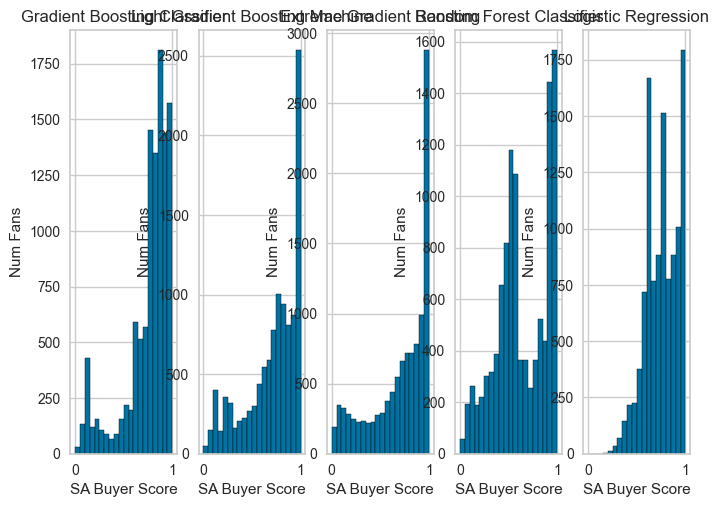

In [14]:
for idx, model in enumerate(models):
    
    plt.subplot(1, 5, idx+1)
    plt.title(model["name"])
    plt.ylabel("Num Fans")
    plt.xlabel("SA Buyer Score")
    plt.hist(model["predictions"]["Score_1"], bins=20, edgecolor="black", range=(0,1))
                            
plt.rcParams["figure.figsize"] = (25,4)
plt.show()

### We can also see how many purchases there are in each range of scores:

In [15]:
for idx, model in enumerate(models):
    print(models[idx]["predictions"]["Label"].value_counts())


1    7623
0    3463
Name: Label, dtype: int64
1    6155
0    4926
Name: Label, dtype: int64
1    6091
0    4890
Name: Label, dtype: int64
0    6654
1    4336
Name: Label, dtype: int64
1    5969
0    5117
Name: Label, dtype: int64


### Select the model you would like to use for updating scores:

In [16]:
selected_model = "Light Gradient Boosting Machine"

for model in models:
    if model["name"] == selected_model:
        df_scores = model["predictions"]
                                 
df_scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11081 entries, 0 to 58524
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   recentdate           11081 non-null  datetime64[ns]
 1   clientcode           11081 non-null  object        
 2   dimcustomermasterid  11081 non-null  int64         
 3   lkupclientid         11081 non-null  int64         
 4   productgrouping      11081 non-null  object        
 5   year                 11081 non-null  int64         
 6   attendancepercent    11081 non-null  float64       
 7   disttovenue          11081 non-null  float64       
 8   inperson_contact     11081 non-null  int64         
 9   missed_games_1       11081 non-null  object        
 10  missed_games_2       11081 non-null  object        
 11  missed_games_over_2  11081 non-null  object        
 12  recency              11081 non-null  int64         
 13  source_tenure        11081 non-

### Optionally we can push these scores into QA so that we can see what the new scoring looks like in the CDP:

In [17]:
CONN = helpers.get_redshift_connection(ENV, DBNAME)

Authorized as AROASQ4JELIXYLYV6P4UV:gdonst@stellaralgo.com


### Insert the scores into the customerretentionscores table in RedShift:

In [18]:
cur = CONN.cursor()

batch_size = 100
df_predictions_list = [
    df_predictions[i:i + batch_size]
    for i in range(0, df_predictions.shape[0], batch_size)
]

print(f"INSERTING {len(df_predictions)} NEW RETENTION SCORES TO DATABASE: {DBNAME} ({LKUPCLIENTID})")

fields = f"""
INSERT INTO {DBNAME}.dw.customerretentionscores (
    attendancePercentage,
    dimcustomermasterid,
    scoredate,
    lkupclientid,
    mostrecentattendance,
    product,
    sascore,
    seasonyear,
    tenuredays
) VALUES """


for i, df_prediction_batch in enumerate(df_predictions_list):

    values_list = []
    for index, row in (df_prediction_batch.iterrows()):
        
        values = f"""
            (
                {str(row.attendancepercent)},
                {str(row.dimcustomermasterid)},
                '{str(datetime.now().strftime("%Y-%m-%d"))}',
                {str(row.lkupclientid)},
                '{str(row.recentdate)}',
                '{str(row.productgrouping)}',
                {str(round((row.Score_1*100),4))},
                {str(row.year)},
                {str(row.source_tenure)}
            )"""

        values_list.append(values)

    insert_statement = fields + ",".join(values_list)+";"

    cur.execute(insert_statement)
    CONN.commit()

    count = cur.rowcount
        
    print(f" > INSERTED BATCH {i+1} : ROWS {i*batch_size + 1} - {i*batch_size + len(values_list)}")

print("RETENTION SCORE INSERTS COMPLETED")

INSERTING 11086 NEW RETENTION SCORES TO DATABASE: stlrnhljets (92)
 > INSERTED BATCH 1 : ROWS 1 - 100
 > INSERTED BATCH 2 : ROWS 101 - 200
 > INSERTED BATCH 3 : ROWS 201 - 300
 > INSERTED BATCH 4 : ROWS 301 - 400
 > INSERTED BATCH 5 : ROWS 401 - 500
 > INSERTED BATCH 6 : ROWS 501 - 600
 > INSERTED BATCH 7 : ROWS 601 - 700
 > INSERTED BATCH 8 : ROWS 701 - 800
 > INSERTED BATCH 9 : ROWS 801 - 900
 > INSERTED BATCH 10 : ROWS 901 - 1000
 > INSERTED BATCH 11 : ROWS 1001 - 1100
 > INSERTED BATCH 12 : ROWS 1101 - 1200
 > INSERTED BATCH 13 : ROWS 1201 - 1300
 > INSERTED BATCH 14 : ROWS 1301 - 1400
 > INSERTED BATCH 15 : ROWS 1401 - 1500
 > INSERTED BATCH 16 : ROWS 1501 - 1600
 > INSERTED BATCH 17 : ROWS 1601 - 1700
 > INSERTED BATCH 18 : ROWS 1701 - 1800
 > INSERTED BATCH 19 : ROWS 1801 - 1900
 > INSERTED BATCH 20 : ROWS 1901 - 2000
 > INSERTED BATCH 21 : ROWS 2001 - 2100
 > INSERTED BATCH 22 : ROWS 2101 - 2200
 > INSERTED BATCH 23 : ROWS 2201 - 2300
 > INSERTED BATCH 24 : ROWS 2301 - 2400
 > 